# Modeling Notebook for Ames, Iowa Housing data. 
---
### Purpose: Best predict sale price for homes using multiple features

### Question: "Using data from Ames Iowa, can we construct a model that will be flexible enough to guide home purchases based on specific housing characteristics?"

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Different models to be tested
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import RandomForestRegressor

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Read in data and separate out target

In [2]:
# Reading in both our training data and our testing data
train_ames  = pd.read_csv('./train.csv', index_col="Id")
test_kaggle = pd.read_csv('./test.csv', index_col="Id")

# Test data size is one less column because there is no target column
train_ames.shape, test_kaggle.shape

((2051, 80), (879, 79))

In [3]:
# Separating our features from our target at the beginning
X = train_ames.drop('SalePrice', axis=1)

y = train_ames['SalePrice']

In [4]:
# Building a testing ground to work with the data.  The small test size is so that we can learn as much as
# possible from the data and test it on a small portion
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.05)

### Small Exploration of the data

In [5]:
# Overview of the dataset
X_train.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
Id,,,,,,,,,,,,,,,,,,,,,
1329,903204010,50,RM,NaN,7425,Pave,NaN,IR1,Bnk,AllPub,...,0,0,0,NaN,NaN,NaN,0,8,2008,WD
1921,535154080,20,RL,75.0,9750,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,NaN,NaN,Shed,500,4,2007,COD
2358,527377030,20,RL,78.0,10140,Pave,NaN,Reg,Lvl,AllPub,...,0,0,648,Fa,GdPrv,NaN,0,1,2006,WD
485,528275160,60,RL,NaN,12891,Pave,NaN,IR1,Lvl,AllPub,...,0,0,0,NaN,NaN,NaN,0,7,2009,WD
1069,528178090,60,RL,112.0,16451,Pave,NaN,IR1,Lvl,AllPub,...,0,0,0,NaN,NaN,NaN,0,7,2008,WD


In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1948 entries, 1329 to 2160
Data columns (total 79 columns):
PID                1948 non-null int64
MS SubClass        1948 non-null int64
MS Zoning          1948 non-null object
Lot Frontage       1635 non-null float64
Lot Area           1948 non-null int64
Street             1948 non-null object
Alley              133 non-null object
Lot Shape          1948 non-null object
Land Contour       1948 non-null object
Utilities          1948 non-null object
Lot Config         1948 non-null object
Land Slope         1948 non-null object
Neighborhood       1948 non-null object
Condition 1        1948 non-null object
Condition 2        1948 non-null object
Bldg Type          1948 non-null object
House Style        1948 non-null object
Overall Qual       1948 non-null int64
Overall Cond       1948 non-null int64
Year Built         1948 non-null int64
Year Remod/Add     1948 non-null int64
Roof Style         1948 non-null object
Roof Matl        

In [7]:
# Overview of the datasets numerical values
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
PID,1948.0,7.145439e+08,1.887572e+08,526301100.0,5.284581e+08,535454065.0,9.071870e+08,924152030.0
MS SubClass,1948.0,5.712012e+01,4.285158e+01,20.0,2.000000e+01,50.0,7.000000e+01,190.0
Lot Frontage,1635.0,6.898287e+01,2.325416e+01,21.0,5.800000e+01,68.0,8.000000e+01,313.0
Lot Area,1948.0,1.008105e+04,6.800510e+03,1300.0,7.500000e+03,9387.0,1.149400e+04,159000.0
Overall Qual,1948.0,6.113963e+00,1.426274e+00,1.0,5.000000e+00,6.0,7.000000e+00,10.0
Overall Cond,1948.0,5.558522e+00,1.103370e+00,1.0,5.000000e+00,5.0,6.000000e+00,9.0
Year Built,1948.0,1.971660e+03,3.024535e+01,1872.0,1.953750e+03,1974.0,2.001000e+03,2010.0
Year Remod/Add,1948.0,1.984190e+03,2.104021e+01,1950.0,1.964000e+03,1993.0,2.004000e+03,2010.0
Mas Vnr Area,1926.0,9.837279e+01,1.739043e+02,0.0,0.000000e+00,0.0,1.577500e+02,1600.0
BsmtFin SF 1,1947.0,4.371767e+02,4.615495e+02,0.0,0.000000e+00,362.0,7.280000e+02,5644.0


## Basic Cleaning of data

In [8]:
# Counting the null values.  Null values seems to indicate something not being present as opposed to incorrect
# or missing values
X_train.isnull().sum()

PID                  0
MS SubClass          0
MS Zoning            0
Lot Frontage       313
Lot Area             0
Street               0
Alley             1815
Lot Shape            0
Land Contour         0
Utilities            0
Lot Config           0
Land Slope           0
Neighborhood         0
Condition 1          0
Condition 2          0
Bldg Type            0
House Style          0
Overall Qual         0
Overall Cond         0
Year Built           0
Year Remod/Add       0
Roof Style           0
Roof Matl            0
Exterior 1st         0
Exterior 2nd         0
Mas Vnr Type        22
Mas Vnr Area        22
Exter Qual           0
Exter Cond           0
Foundation           0
                  ... 
Full Bath            0
Half Bath            0
Bedroom AbvGr        0
Kitchen AbvGr        0
Kitchen Qual         0
TotRms AbvGrd        0
Functional           0
Fireplaces           0
Fireplace Qu       955
Garage Type        105
Garage Yr Blt      106
Garage Finish      106
Garage Cars

In [9]:
train_ames.columns

Index(['PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street',
       'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config',
       'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Fireplace Qu',
       'Garage Type', 'Garage Yr Blt', 'Garage Finish'

In [10]:
def drop_data(data):
    """
    Remove unused columns.  Decision based on Training data low usage or 
    challenge to come up with methods to impute.
    data = dataframe
    """
    dropped = data[['PID', 'Misc Feature']]
    noneed_features = data.drop(dropped, axis=1)
    return noneed_features

X_train = drop_data(X_train)
X_test = drop_data(X_test)
test_kaggle = drop_data(test_kaggle)

In [11]:
X_train.shape, X_test.shape, test_kaggle.shape

((1948, 77), (103, 77), (879, 77))

In [12]:
# Target the columns with null values
null_columns = X_train.columns[X_train.isnull().any()]
X_train[null_columns].isnull().sum()

Lot Frontage       313
Alley             1815
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Qual           53
Bsmt Cond           53
Bsmt Exposure       56
BsmtFin Type 1      53
BsmtFin SF 1         1
BsmtFin Type 2      54
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Bsmt Full Bath       2
Bsmt Half Bath       2
Fireplace Qu       955
Garage Type        105
Garage Yr Blt      106
Garage Finish      106
Garage Cars          1
Garage Area          1
Garage Qual        106
Garage Cond        106
Pool QC           1939
Fence             1567
dtype: int64

In [13]:
def null_fill(data):
    """
    Filling null values with proper corresponding information
    Keeping maintaining columns type as object, integer, or float
    data = dataframe
    """
    filled_data = data.copy()
    fillna_dict = {'Garage Qual'   : 'No_garage', 
                   'Garage Cond'   : 'No_garage',
                   'Garage Finish' : 'No_garage',
                   'Garage Type'   : 'No_garage',
                   'Garage Yr Blt' : 'No_garage', 
                   'Garage Area'   :  0.0,
                   'Garage Cars'   :  0,
                   'Bsmt Qual'     : 'No_bsmt',
                   'Bsmt Exposure' : 'No_bsmt',
                   'Total Bsmt SF' :  0.0,
                   'Bsmt Full Bath':  0,
                   'Bsmt Half Bath':  0,
                   'BsmtFin Type 1': 'No_bsmt', 
                   'BsmtFin SF 1'  :  0.0, 
                   'BsmtFin Type 2': 'No_bsmt',
                   'BsmtFin SF 2'  :  0.0,
                   'Bsmt Unf SF'   :  0.0, 
                   'Bsmt Cond'     : 'No_bsmt',
                   'Mas Vnr Type'  : 'None',
                   'Mas Vnr Area'  :  0.0,
                    # Assumption that the front of the house is the length of lot frontage. Square footage
                    # divided into a quarter should give an approximate answer
                   'Lot Frontage'  :  (0.25 * data['1st Flr SF']),
                   'Alley'         : 'No_alley',
                   'Pool QC'       : 'No_pool',
                   'Fence'         : 'No_fence',
                   'Fireplace QC'  : 'No_fireplace'
                  }
    filled_data = filled_data.fillna(fillna_dict)
    return filled_data

X_train = null_fill(X_train)
X_test = null_fill(X_test)
test_kaggle = null_fill(test_kaggle)

In [14]:
X_train.shape, X_test.shape, test_kaggle.shape

((1948, 77), (103, 77), (879, 77))

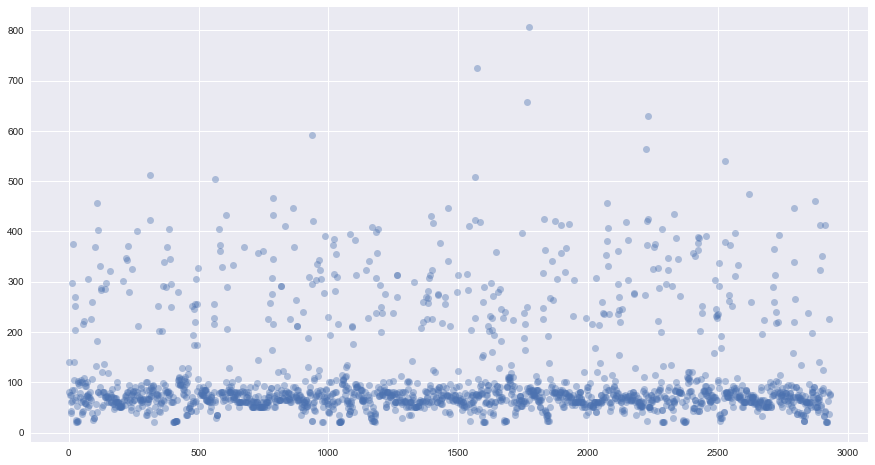

In [15]:
# Ensuring that the spread of lot frontage being ok.
plt.figure(figsize=(15, 8))
plt.plot(X_train['Lot Frontage'], 'o', alpha=0.4);

In [16]:
def change_types(data):
    """
    Numerical values that are better served as objects
    data = dataframe
    """
    data['MS SubClass']    = data['MS SubClass'].astype(str)
    data['Overall Qual']   = data['Overall Qual'].astype(str)
    data['Overall Cond']   = data['Overall Cond'].astype(str)
    data['Mo Sold']        = data['Mo Sold'].astype(str)
    data['Year Built']     = data['Year Built'].astype(str)
    return data

X_train = change_types(X_train)
X_test  = change_types(X_test)
test_kaggle = change_types(test_kaggle)

In [17]:
# establishing the object columns to be dummied
string_cols = X_train.select_dtypes(exclude=[np.number]).columns

X_train = pd.get_dummies(X_train, columns=string_cols)
X_test  = pd.get_dummies(X_test, columns=string_cols)
test_kaggle = pd.get_dummies(test_kaggle, columns=string_cols)

In [18]:
# column shape will be different based on data that may not be in every dataframe
X_train.shape, X_test.shape, test_kaggle.shape

((1948, 551), (103, 362), (879, 519))

In [19]:
def interactive_features(data):
    """
    Based on Subject Matter Expertise, creating new features based on interactions
    data = dataframe
    """
    data['Bath_Bed'] = (data['Full Bath'] + data['Half Bath']) * (data['Bedroom AbvGr'] + data['TotRms AbvGrd'])
    data['Baths']    = data['Full Bath'] + data['Half Bath']
    data['Bedrooms'] = data['Bedroom AbvGr'] + data['TotRms AbvGrd']
    data['Total SF'] = data['Total Bsmt SF'] + data['1st Flr SF'] + data['2nd Flr SF']
    return data

X_train = interactive_features(X_train)
X_test  = interactive_features(X_test)
test_kaggle = interactive_features(test_kaggle)

In [20]:
model_cols = X_train.columns

def add_model_cols(data, model_cols):
    """
    Verify and add new columns to the test data if the columns are not in our training model.
    data = dataframe
    model_cols = columns in training that will be paired with testing columns
    """
    new_data = data.copy()
    for missing_col in [col for col in model_cols if col not in data.columns]:
        new_data[missing_col] = 0 # missing columns can be 0 after all data is now numeric
    return new_data

X_test = add_model_cols(X_test, model_cols=model_cols)
test_kaggle = add_model_cols(test_kaggle, model_cols=model_cols)

In [21]:
test_kaggle = test_kaggle[model_cols]
X_test      = X_test[model_cols]

In [22]:
# With all models having the same column length, we an begin testing the model
X_train.shape, X_test.shape, test_kaggle.shape

((1948, 555), (103, 555), (879, 555))

### Modeling using Ridge, Lasso, Elastic Net, and Linear Regression

In [23]:
# Scale the data since majority of the data is going to be varying in size
data_columns = X_train.columns # to see which columns are best fit
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test  = ss.transform(X_test)
test_kaggle = ss.transform(test_kaggle)

In [24]:
# Ridge Regression focuses on shrinking coeficients values
r_alphas = np.logspace(0, 5, 200) # generates 200 points between 10^0, 10^5
ridge = RidgeCV(alphas=r_alphas)
ridge.fit(X_train, y_train)

print("Ridge best alpha:", ridge.alpha_)
print("\nRidge Training Score:", ridge.score(X_train, y_train))
print("\nRidge Testing Score:", ridge.score(X_test, y_test))

print("5 largest positive effects on housing price:\n",
      list(sorted(zip(ridge.coef_, data_columns), reverse=True))[:5])
print("\n5 largest negative effects on housing price:\n",
      list(sorted(zip(ridge.coef_, data_columns), reverse=True))[-5:])

Ridge best alpha: 1096.985797892384

Ridge Training Score: 0.9218786062927355

Ridge Testing Score: 0.9387663965170255
5 largest positive effects on housing price:
 [(5085.199949126714, 'Overall Qual_9'), (4960.773087282212, 'Total SF'), (4913.790507741613, 'Gr Liv Area'), (4348.505562838103, 'Kitchen Qual_Ex'), (4050.9517287812046, '1st Flr SF')]

5 largest negative effects on housing price:
 [(-2013.5321002215485, 'Overall Qual_5'), (-2020.7896954935445, 'Kitchen Qual_TA'), (-2267.934503564025, 'Exter Qual_TA'), (-3800.2581794135513, 'Misc Val'), (-5943.828052723315, 'Roof Matl_ClyTile')]


In [25]:
# Lasso Regression is focusing on reducing unimportant values to 0
las = LassoCV(n_jobs=-1)
las.fit(X_train, y_train)
cv_scores = cross_val_score(las, X_train, y_train, cv=3).mean()
print("Lasso Best Alpha:", las.alpha_)
print("\nLasso Training Score:", las.score(X_train, y_train))
print("\nLasso Testing Score:", las.score(X_test, y_test))

print("5 largest positive effects on housing price:\n",
      list(sorted(zip(las.coef_, data_columns), reverse=True))[:5])
print("\n5 largest negative effects on housing price:\n",
      list(sorted(zip(las.coef_, data_columns), reverse=True))[-5:])

Lasso Best Alpha: 811.7454074906838

Lasso Training Score: 0.92406574094026

Lasso Testing Score: 0.9412799502124061
5 largest positive effects on housing price:
 [(15786.815956963655, 'Total SF'), (10979.749037967451, 'Gr Liv Area'), (9503.46531435509, 'Overall Qual_9'), (6653.781429083146, 'Overall Qual_8'), (6558.484650409608, 'Overall Qual_10')]

5 largest negative effects on housing price:
 [(-1493.0905586183953, 'Kitchen Qual_TA'), (-2773.994076814211, 'Exter Qual_TA'), (-2906.870172233729, 'Overall Cond_3'), (-6186.382173996328, 'Misc Val'), (-11912.967020893018, 'Roof Matl_ClyTile')]


In [26]:
# Basic Linear Regression Model
lr = LinearRegression()
lr.fit(X_train, y_train)
print("Linear Regression Training Score:", lr.score(X_train, y_train))
print("Linear Regression Testing Score:", lr.score(X_test, y_test))

print("5 largest positive effects on housing price:\n",
      list(sorted(zip(lr.coef_, data_columns), reverse=True))[:5])
print("\n5 largest negative effects on housing price:\n",
      list(sorted(zip(lr.coef_, data_columns), reverse=True))[-5:])

Linear Regression Training Score: 0.9409736257155035
Linear Regression Testing Score: 0.9299239300289686
5 largest positive effects on housing price:
 [(3.7661306876941e+17, 'Exter Cond_TA'), (3.418339848784308e+17, 'Exter Cond_Gd'), (2.0642027189502368e+17, 'Street_Pave'), (2.064202718950234e+17, 'Street_Grvl'), (1.771707259386453e+17, 'BsmtFin Type 2_Unf')]

5 largest negative effects on housing price:
 [(-1.8575041750517824e+17, 'Lot Config_Corner'), (-2.1865559018226246e+17, 'Lot Config_Inside'), (-2.4871024315174394e+17, 'MS Zoning_I (all)'), (-2.6250022326523264e+17, 'Utilities_NoSeWa'), (-3.711360294230722e+17, 'Utilities_AllPub')]


In [27]:
# combination on the penalties of Lasso and Ridge
en = ElasticNetCV()
en.fit(X_train, y_train)
print("Elastic Net Training Score:", en.score(X_train, y_train))
print("\nElastic Net Testing Score:", en.score(X_test, y_test))

print("5 largest positive effects on housing price:\n",
      list(sorted(zip(en.coef_, data_columns), reverse=True))[:5])
print("\n5 largest negative effects on housing price:\n",
      list(sorted(zip(en.coef_, data_columns), reverse=True))[-5:])

Elastic Net Training Score: 0.34216389530599467

Elastic Net Testing Score: 0.3521809879375464
5 largest positive effects on housing price:
 [(778.6974802589391, 'Total SF'), (696.7546378538474, 'Gr Liv Area'), (632.842722606635, 'Garage Area'), (626.6749341157986, 'Garage Cars'), (620.4845022254473, '1st Flr SF')]

5 largest negative effects on housing price:
 [(-388.1496308673164, 'Mas Vnr Type_None'), (-405.945056222399, 'Garage Finish_Unf'), (-420.3697655400883, 'Bsmt Qual_TA'), (-520.1063771389961, 'Kitchen Qual_TA'), (-575.7585816391734, 'Exter Qual_TA')]


In [28]:
# Quick comparison of the models
print("Ridge Test:", ridge.score(X_test, y_test))
print()
print("Lasso Test:", las.score(X_test, y_test))
print()
print("LinearRegression", lr.score(X_test, y_test))
print()
print("ElasticNet Test:", en.score(X_test, y_test))

Ridge Test: 0.9387663965170255

Lasso Test: 0.9412799502124061

LinearRegression 0.9299239300289686

ElasticNet Test: 0.3521809879375464


In [29]:
# Creating a csv with our predictions for the Kaggle Dataset
y_pred_lasso = las.predict(test_kaggle)
submit = pd.read_csv('./test.csv', index_col="Id")
submit['SalePrice'] = y_pred_lasso
submit = submit[['SalePrice']]
submit.to_csv('submission_lasso.csv')

In [30]:
submit.head()

,SalePrice
Id,
2658,124999.982761
2718,164918.061417
2414,215385.376030
1989,119427.904833
625,184064.113805
